# **Movie Data Analysis**

**Import Packages**

In [12]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from movie_package import movie_package

**Pull Rotten Tomatoes Data**

In [13]:
url1 = 'https://www.rottentomatoes.com/franchise/marvel_cinematic_universe'
request1 = requests.get(url1)
bs1 = BeautifulSoup(request1.content)

**Pull Wikipedia Data**

In [14]:
url2 = 'https://en.m.wikipedia.org/wiki/List_of_films_based_on_Marvel_Comics_publications'
tables = pd.read_html(url2)

**Make Rotten Tomatoes Dataframe**

In [15]:
# Make Dataframe
movie_info = pd.DataFrame()

# Get Titles
titles = bs1.find_all('a', {'data-qa': 'franchise-media-link'})

# Extract the text from the links
title = [movie.get_text(strip=True) for movie in titles]

# Add title to Dataframe
movie_info['title'] = title

In [16]:
# Get Years
years = bs1.find_all('span', {'data-qa': 'franchise-media-year'})

# Create the list of years
year = [movie_package.clean_year(movie.get_text(strip=True)) for movie in years]

# Add year to dataframe
movie_info['year'] = year

In [17]:
# Get Director
director = bs1.find_all('div', {'data-qa': ['franchise-media-director', 'franchise-media-producer']})

directors_producers = movie_package.extract_names(director)

# Add director to dataframe
movie_info['director'] = directors_producers

In [18]:
# Get tomato meter score
complete_list = bs1.find_all('li', {'data-qa': 'franchise-media-item'})

tomato_meter = movie_package.clean_tomato(complete_list)

# Add critic rating to dataframe
movie_info['critic_rating'] = tomato_meter

In [19]:
# Get popcorn meter score
popcorn_meter = movie_package.clean_popcorn(complete_list)

# Add user rating to dataframe
movie_info['user_rating'] = popcorn_meter

**Make Wikipedia Dataframe**

In [20]:
# Get Box office table
box_office = tables[14]

# Drop messy heading using
box_office.columns = box_office.columns.droplevel(0)

# Rename columns
new_names = ['title', 'distributor', 'release_date_us', 'budget', 'rev_opening_weekend_NA', 'rev_NA', 'rev_not_NA', 'rev_worldwide']
box_office.columns = new_names


**Join the Two Tables**

In [21]:
# Join on title column
movie_final = pd.merge(movie_info, box_office, on='title', how='inner')
movie_final.head()

,title,year,director,critic_rating,user_rating,distributor,release_date_us,budget,rev_opening_weekend_NA,rev_NA,rev_not_NA,rev_worldwide
0,Deadpool & Wolverine,2024,Shawn Levy,78.0,94.0,Walt Disney Studios Motion Pictures,"July 26, 2024",$200,"$211,435,291","$636,745,858","$701,327,524","$1,338,073,382"
1,The Marvels,2023,Nia DaCosta,62.0,81.0,Walt Disney Studios Motion Pictures,"November 10, 2023",$274.8,"$46,110,859","$84,500,223","$121,636,602","$206,136,825"
2,Guardians of the Galaxy Vol. 3,2023,James Gunn,82.0,94.0,Walt Disney Studios Motion Pictures,"May 5, 2023",$250,"$118,414,021","$358,995,815","$486,559,962","$845,555,777"
3,Black Panther: Wakanda Forever,2022,Ryan Coogler,84.0,94.0,Walt Disney Studios Motion Pictures,"November 11, 2022",$250,"$181,339,761","$453,829,060","$405,378,853","$859,207,913"
4,Thor: Love and Thunder,2022,Taika Waititi,63.0,76.0,Walt Disney Studios Motion Pictures,"July 8, 2022",$200,"$144,165,107","$343,256,830","$417,671,251","$760,928,081"


**Clean the Final Dataset**

In [31]:
# Cleaning the data

# Convert budget to float, same scale as revenue
movie_final['budget'] = movie_final['budget'].replace('\$', '', regex = True).astype(float)
movie_final['budget'] = movie_final['budget'] * 1000000

# Clean revenues, convert to integers
movie_final['rev_opening_weekend_NA'] = movie_final['rev_opening_weekend_NA'].replace({'\$': '', ',': ''}, regex = True).astype(float)
movie_final['rev_NA'] = movie_final['rev_NA'].replace({'\$': '', ',': ''}, regex = True).astype(float)
movie_final['rev_not_NA'] = movie_final['rev_not_NA'].replace({'\$': '', ',': ''}, regex = True).astype(float)
movie_final['rev_worldwide'] = movie_final['rev_worldwide'].replace({'\$': '', ',': ''}, regex = True).astype(float)

movie_final.head()

,title,year,director,critic_rating,user_rating,distributor,release_date_us,budget,rev_opening_weekend_NA,rev_NA,rev_not_NA,rev_worldwide
0,The Marvels,2023,Nia DaCosta,62.0,81.0,Walt Disney Studios Motion Pictures,"November 10, 2023",274800000.0,46110859.0,84500223.0,121636602.0,206136825.0
1,Guardians of the Galaxy Vol. 3,2023,James Gunn,82.0,94.0,Walt Disney Studios Motion Pictures,"May 5, 2023",250000000.0,118414021.0,358995815.0,486559962.0,845555777.0
2,Black Panther: Wakanda Forever,2022,Ryan Coogler,84.0,94.0,Walt Disney Studios Motion Pictures,"November 11, 2022",250000000.0,181339761.0,453829060.0,405378853.0,859207913.0
3,Thor: Love and Thunder,2022,Taika Waititi,63.0,76.0,Walt Disney Studios Motion Pictures,"July 8, 2022",200000000.0,144165107.0,343256830.0,417671251.0,760928081.0
4,Doctor Strange in the Multiverse of Madness,2022,Sam Raimi,74.0,85.0,Walt Disney Studios Motion Pictures,"May 6, 2022",200000000.0,187420998.0,411331607.0,544444197.0,955775804.0


**Export Final Dataset to movie_final.csv**

In [36]:
movie_final.to_csv('movie_final.csv', index=False)

# **Analysis**

**Relationship Between Budget and Revenue**

Text(0, 0.5, 'North America Revenue (in millions)')

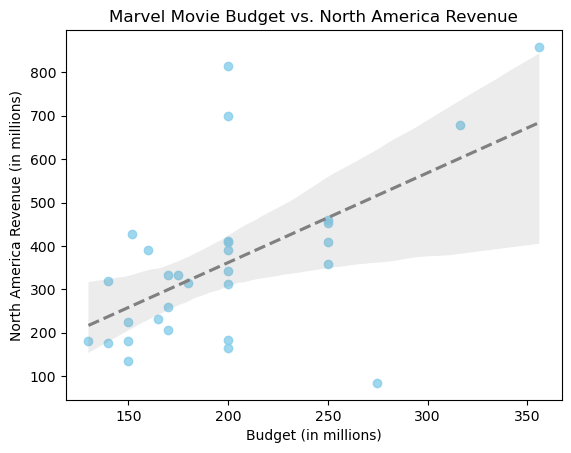

In [13]:
# Convert to millions for ease
movie_final_temp = movie_final
movie_final_temp['budget'] = movie_final['budget'] / 1000000
movie_final_temp['rev_worldwide'] = movie_final['rev_worldwide'] / 1000000
movie_final_temp['rev_NA'] = movie_final['rev_NA'] / 1000000

# Scatterplot of budget and North America
sns.regplot(x = 'budget', y = 'rev_NA', line_kws={'color': 'gray', 'linestyle': '--'}, scatter_kws={'color': 'skyblue'}, data = movie_final_temp)

# Customize plot
plt.title('Marvel Movie Budget vs. North America Revenue')
plt.xlabel('Budget (in millions)')
plt.ylabel('North America Revenue (in millions)')


In [14]:
correlation_coefficient1 = np.corrcoef(movie_final['budget'], movie_final['rev_NA'])[0, 1]
correlation_coefficient1

0.5706855565729658

**Relationship Between Opening Weekend Revenue and Overall Revenue**

Text(0, 0.5, 'Overall Revenue (in millions)')

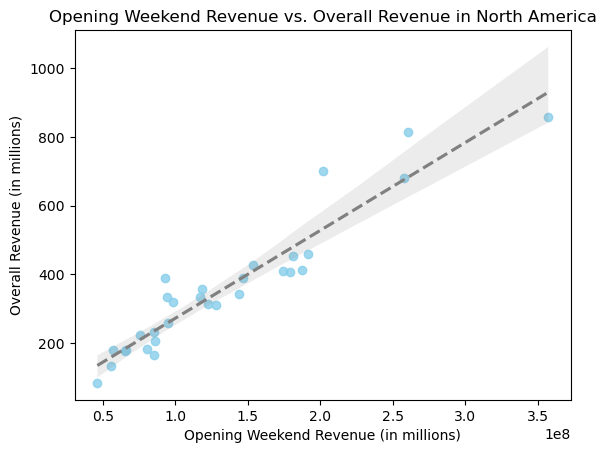

In [15]:
# Scatterplot between opening weekend revenue in North America and overall revenue in North America
sns.regplot(x = 'rev_opening_weekend_NA', y = 'rev_NA', line_kws={'color': 'gray', 'linestyle': '--'}, scatter_kws={'color': 'skyblue'}, data = movie_final_temp)

# Customize plot
plt.title('Opening Weekend Revenue vs. Overall Revenue in North America')
plt.xlabel('Opening Weekend Revenue (in millions)')
plt.ylabel('Overall Revenue (in millions)')


In [16]:
# Correlation Coefficient between opening weekend revenue and overall revenue (North America)
correlation_coefficient2 = np.corrcoef(movie_final['rev_opening_weekend_NA'], movie_final['rev_NA'])[0, 1]
correlation_coefficient2

0.947046079908735

**Long Term Trajectory of User and Critic Ratings**

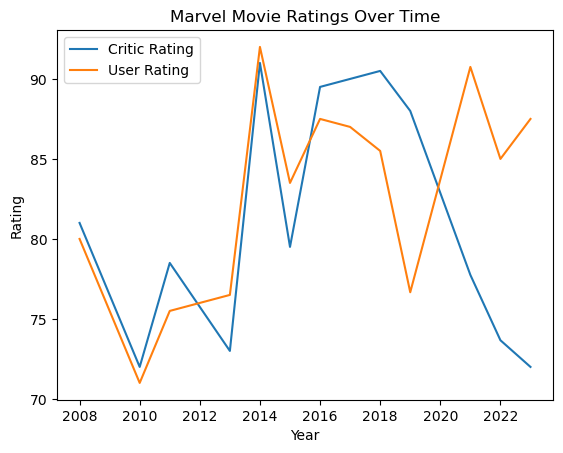

In [17]:
# Assuming 'movie_final' is your DataFrame
sns.lineplot(x='year', y='critic_rating', data=movie_final, label='Critic Rating', errorbar = None)
sns.lineplot(x='year', y='user_rating', data=movie_final, label='User Rating', errorbar = None)

plt.title('Marvel Movie Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.legend()

**Director's Impact on Critic vs. User Ratings**

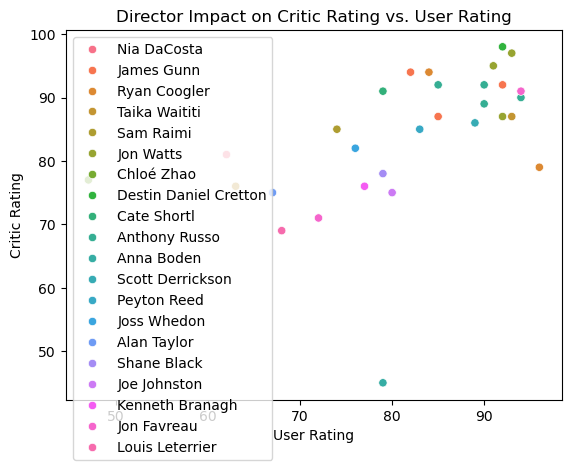

In [18]:
# Scatterplot of critic ratings vs. user ratings with directors color-coded
sns.scatterplot(x = 'critic_rating', y = 'user_rating', hue = 'director', data = movie_final_temp)

# Customize plot
plt.title('Director Impact on Critic Rating vs. User Rating')
plt.xlabel('User Rating')
plt.ylabel('Critic Rating')
plt.legend()

**Relationship Between Critic Rating and Overall Revenue**

Text(0, 0.5, 'Worldwide Revenue (in millions)')

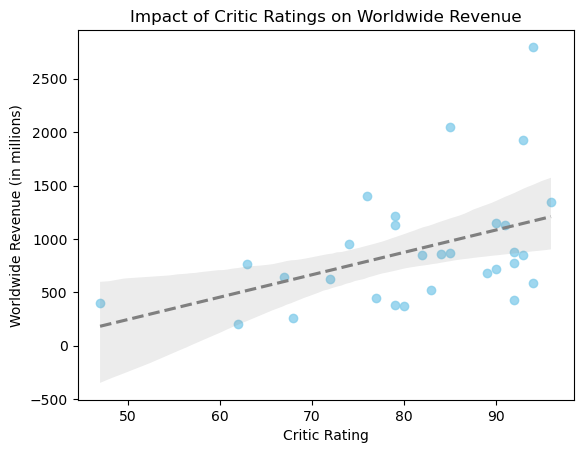

In [ ]:
# Scatterplot of Critic rating vs. worldwide revenue
sns.regplot(x = 'critic_rating', y = 'rev_worldwide', line_kws={'color': 'gray', 'linestyle': '--'}, scatter_kws={'color': 'skyblue'}, data = movie_final_temp)

# Customize plot
plt.title('Impact of Critic Ratings on Worldwide Revenue')
plt.xlabel('Critic Rating')
plt.ylabel('Worldwide Revenue (in millions)')

In [ ]:
# Correlation Coefficient between opening weekend revenue and overall revenue (North America)
correlation_coefficient3 = np.corrcoef(movie_final['critic_rating'], movie_final['rev_worldwide'])[0, 1]
correlation_coefficient3

0.4324276875605945

**Impact of Marvel Movie Budget on User Ratings**

Text(0, 0.5, 'User Rating')

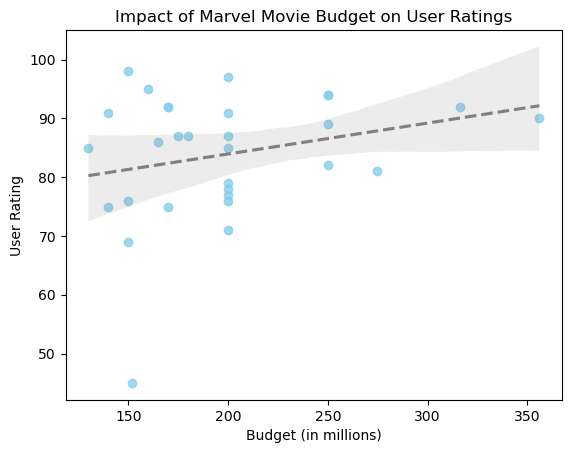

In [ ]:
# Scatterplot Between budget and user ratings
sns.regplot(x = 'budget', y = 'user_rating', line_kws={'color': 'gray', 'linestyle': '--'}, scatter_kws={'color': 'skyblue'}, data = movie_final_temp)

# Customize plot
plt.title('Impact of Marvel Movie Budget on User Ratings')
plt.xlabel('Budget (in millions)')
plt.ylabel('User Rating')

In [ ]:
# Correlation Coefficient between budget and user rating
correlation_coefficient3 = np.corrcoef(movie_final['user_rating'], movie_final['budget'])[0, 1]
correlation_coefficient3

0.2579968247383432

**Worldwide Revenue by Year (Impact of COVID)**

Text(0, 0.5, 'Worldwide Revenue')

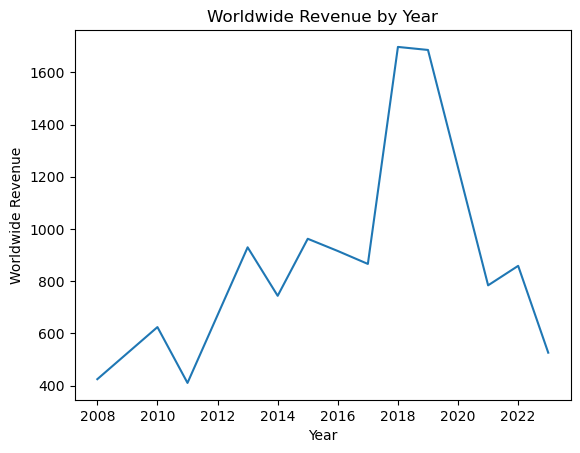

In [ ]:
# Lineplot of worldwide revenue by year
sns.lineplot(x='year', y='rev_worldwide', data=movie_final_temp, errorbar = None)

# Customize plot
plt.title('Worldwide Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Worldwide Revenue')


# Regression Model to Predict Movie Success

**Model to Predict Revenue**

In [ ]:
# Set main effects and add the constant term
X = movie_final[['budget', 'user_rating', 'year', 'rev_opening_weekend_NA']]
X = sm.add_constant(X)  # Add a constant term
y = movie_final['rev_worldwide']

# Fit model for revenue
movie_rev_lm = sm.OLS(y, X).fit()

# Print out summary of model
movie_rev_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rev_worldwide   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     57.09
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           3.28e-12
Time:                        21:48:22   Log-Likelihood:                -197.51
No. Observations:                  30   AIC:                             405.0
Df Residuals:                      25   BIC:                             412.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.527e+04   1.84e+04      0.831      0.414   -2.26e+04    5.31e+04
budget                    -0.2513      1.028     -0.244      0.809      -2.369       1.867
user_rating                3.7188      3.472      1.071      0.294      -3.433      10.871
year                      -7.7614      9.171     -0.846      0.405     -26.650      11.127
rev_opening_weekend_NA  7.685e-06    7.1e-07     10.826      0.000    6.22e-06    9.15e-06
==============================================================================
Omnibus:                        2.953   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.228   Jarque-Bera (JB):                1.714
Skew:                           0.207   Prob(JB):                        0.424
Kurtosis:                       4.095   Cond. No.                     7.92e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.92e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model to Predict User Rating**

In [20]:
# Set main effects and add the constant term
X = movie_final[['budget', 'rev_worldwide', 'critic_rating']]
X = sm.add_constant(X)  # Add a constant term
y = movie_final['user_rating']

# Fit model for revenue
movie_rating_lm = sm.OLS(y, X).fit()

# Print out summary of model
movie_rating_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            user_rating   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     6.661
Date:                Sun, 08 Dec 2024   Prob (F-statistic):            0.00174
Time:                        18:40:28   Log-Likelihood:                -104.96
No. Observations:                  30   AIC:                             217.9
Df Residuals:                      26   BIC:                             223.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.6765     16.528      0.706      0.486     -22.296      45.649
budget            0.1240      0.044      2.791      0.010       0.033       0.215
rev_worldwide    -0.0098      0.005     -2.122      0.044      -0.019      -0.000
critic_rating     0.6923      0.169      4.098      0.000       0.345       1.040
==============================================================================
Omnibus:                       17.427   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.903
Skew:                          -1.286   Prob(JB):                     1.44e-06
Kurtosis:                       6.861   Cond. No.                     1.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""